In [130]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC,  LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, precision_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
import xgboost as xgb
from classification_model import xgb_classification, lgb_classification_2, svm_classification_2, calculate_precision
rus = RandomUnderSampler(random_state=2021)

In [131]:
def plt_hist(plt_data, keys=['IN', 'TP', 'FN']):
    plt.figure(figsize=(150, 25))
    ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == keys[0]]['len_trace'], color='red')
    ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == keys[1]]['len_trace'], color='green')
    ax = sns.barplot(x=plt_data['no'], y=plt_data[plt_data['kind'] == keys[2]]['len_trace'], color='blue')
    plt.show()

In [132]:
def plt_pie(plt_data):
    freq = plt_data['kind'].value_counts()
    plt.pie(freq, labels=freq.index, explode=(0.05, 0, 0), autopct='%.1f%%',
            colors=['#81ecec','#ff7675','#6c5ce7'], startangle=90, counterclock=False)
    plt.show()

In [133]:
def confusion(x, data, feat):
    t = x
    all_val = data
    P = all_val[all_val['label'] == 1]
    TP = all_val[(all_val['label'] == 1) & (all_val['label'] == t)]
    FP = all_val[(all_val['label'] == 0) & (all_val['label'] != t)]
    TP = TP[feat + ['no', 'label']]
    FP = FP[feat + ['no', 'label']]

    N = all_val[all_val['label'] == 0]
    FN = all_val[(all_val['label'] == 1) & (all_val['label'] != t)]
    TN = all_val[(all_val['label'] == 0) & (all_val['label'] == t)]
    TN = TN[feat + ['no', 'label']]
    FN = FN[feat + ['no', 'label']]
    a, b =all_val[all_val['label']==1]['no'].drop_duplicates().shape[0], all_val[all_val['label']==0]['no'].drop_duplicates().shape[0]
    print(all_val.shape)
    print(TP.shape[0], FP.shape[0], TN.shape[0], FN.shape[0], a, b)
    return TP, FP, TN, FN

In [134]:
def get_no_ls(x, val_data, all_real_no, val_no, feat):
    TP, FP, TN, FN = confusion(x, val_data, feat)
    tp_no, fp_no = TP['no'].drop_duplicates(), FP['no'].drop_duplicates()
    tn_no, fn_no = TN['no'].drop_duplicates(), FN['no'].drop_duplicates()
    tp_ls = []
    for i in tp_no.index:
        tp_ls.append(tp_no[i])
    fp_ls = []
    for i in fp_no.index:
        fp_ls.append(fp_no[i])
    tn_ls = []
    for i in tn_no.index:
        tn_ls.append(tn_no[i])
    fn_ls = []
    for i in fn_no.index:
        fn_ls.append(fn_no[i])
    all_real_ls = []
    for i in all_real_no.index:
        all_real_ls.append(all_real_no[i])
    val_ls = []
    for i in val_no.index:
        val_ls.append(val_no[i])
    print(tp_no.shape[0], fp_no.shape[0], tn_no.shape[0], fn_no.shape[0])
    return tp_ls, fp_ls, tn_ls, fn_ls, all_real_ls, val_ls

In [135]:
def get_plt_data(val_indf, tp_ls, fp_ls, tn_ls, fn_ls, tp_fn, fp_tn):
    val_indf_tp = val_indf[(val_indf['no'].isin(tp_ls)) & (~val_indf['no'].isin(tp_fn))]
    val_indf_tp['kind'] = 'TP'
    val_indf_fn = val_indf[(val_indf['no'].isin(fn_ls)) & (~val_indf['no'].isin(tp_fn))]
    val_indf_fn['kind'] = 'FN'
    # tp fn交集
    val_indf_in = val_indf[val_indf['no'].isin(tp_fn)]
    val_indf_in['kind'] = 'IN'

    val_indf_fp = val_indf[(val_indf['no'].isin(fp_ls)) & (~val_indf['no'].isin(fp_tn))]
    val_indf_fp['kind'] = 'FP'
    val_indf_tn = val_indf[(val_indf['no'].isin(tn_ls)) & (~val_indf['no'].isin(fp_tn))]
    val_indf_tn['kind'] = 'TN'
    # fp tn交集
    val_indf_in2 = val_indf[(val_indf['no'].isin(fp_tn))]
    val_indf_in2['kind'] = 'IN2'
    plt_data2 = pd.concat([val_indf_tp, val_indf_fn, val_indf_in, val_indf_fp, val_indf_tn, val_indf_in2])
    plt_data = pd.concat([val_indf_tp, val_indf_in, val_indf_fn])
    return plt_data

In [136]:
def read_data_to_train(df):
    y = df['label']
    no = df['no']
    no_cols = ['Unnamed: 0', 'label', 'no', 'id']
    
    # pca降维
    pca = PCA(n_components=0.9)
    X = pca.fit_transform(df[[i for i in df.columns if i not in no_cols]])
    X = pd.DataFrame(data=X, columns=list(range(X.shape[1])))
    print(df.shape)
    X['no'] = no
    X['label'] = y
    # X['id'] = list(range(df.shape[0]))
    print(X.shape)
    # 正例细胞的编号
    p_no = df[df['label'] == 1]['no'].drop_duplicates()

    ## 将所有正例作为验证集合
    all_p = X[X['no'].isin(p_no)]
    part_np = X[~X['no'].isin(p_no)].sample(n=all_p.shape[0], replace=False, random_state=2021)
    all_val = pd.concat([all_p, part_np])

    # 将正例中1/10的编号作为验证集合
    val_no = p_no.sample(n=p_no.shape[0]//10, replace=False, random_state=2021)
    print(val_no.shape, p_no.shape)
    # p_no中除去作为验证集后剩余的9/10
    p_no = p_no[~ p_no.isin(val_no)]
    # 将编号对应的验证数据取出
    val_X = X[X['no'].isin(val_no)]
    # 将不在训练集中的其他数据作为验证集
    trn_X = X[~ X['no'].isin(val_no)]
    feat = [i for i in trn_X.columns if i not in ['label', 'no']]
    # 加上id便于在取负例验证数据时去重
    trn_X['id'] = list(range(trn_X.shape[0]))
    # 负采样
    X_resampled, y_resampled = rus.fit_resample(trn_X, trn_X['label'])
    # 训练集数据的编号
    trn_no = X_resampled['id'].drop_duplicates()
    print(trn_no.shape, p_no.shape)
    # a = trn_X[~trn_X['no'].isin(trn_no)]
    a = trn_X[~trn_X['id'].isin(trn_no)]
    print(sorted(Counter(y_resampled).items()),
          trn_X.shape, trn_no.shape, a.shape, val_X.shape)
    val_X_np = a.sample(n=val_X.shape[0], replace=False, random_state=2021)
    print(val_X_np[val_X_np['label'] == 1]['no'].drop_duplicates().shape)
    val_X = pd.concat([val_X, val_X_np])
    return val_X, X_resampled, y_resampled, feat, all_val


In [ ]:
class Model_Result():
    def __init__(tp, p, precision, self) -> None:
        self.tp = tp
        self.p = p
        self.precision = precision

In [142]:
from functools import cmp_to_key


def cmp(a, b):
    a = a.split('_')
    b = b.split('_')
    a1, a2 = int(a[0]), int(a[1])
    b1, b2 = int(b[0]), int(b[1])
    return a1-b1 if a2 == b2 else a2-b2


def diff_win_len(df, origin_data):
    # read data
    val_X, X_resampled, y_resampled, feat, all_val = read_data_to_train(df)
    # svm val_X
    svm_clf = Pipeline(
        (
            ('scaler', StandardScaler()),
            ('svm_clf', SVC(kernel='rbf', C=10, gamma=0.1))
        )
    )
    y_predict, y_true = svm_classification_2(X_resampled, svm_clf, feat)
    a = svm_clf.predict(val_X[feat])
    cal_tp, cal_p, rate = calculate_precision(a, val_X['label'])
    svm_res = Model_Result(cal_tp, cal_p, rate)

    # lgb all_val
    val_data = all_val
    a, d, e, f = lgb_classification_2(X_resampled, val_data[feat], feat)
    x = np.mean(d, axis=0)
    x = x > 0.5
    cal_tp, cal_p, rate = calculate_precision(x, val_data['label'])
    lgb_res = Model_Result(cal_tp, cal_p, rate)

    # lgb val_X
    val_data = val_X
    a, d, e, f = lgb_classification_2(X_resampled, val_data[feat], feat)
    x = np.mean(d, axis=0)
    x = x > 0.5
    cal_tp, cal_p, rate = calculate_precision(x, val_data['label'])
    lgb_res2 = Model_Result(cal_tp, cal_p, rate)
    print(rate)

    # 验证混淆矩阵
    val_no = val_X[val_X['label'] == 1]['no'].drop_duplicates()
    all_real_no = all_val['no'].drop_duplicates()
    tp_ls, fp_ls, tn_ls, fn_ls, all_real_ls, val_ls = get_no_ls(
        x, val_data, all_real_no, val_no, feat)
    # 即被分为fp也被分为tn
    fp_tn = [i for i in fp_ls if i in tn_ls]
    print('len -> fp_tn: {}, fp_ls: {}, tn_ls: {}'.format(len(fp_tn),
          len(fp_ls), len(tn_ls)))
    # 既被分为p也被分为n
    tp_fn = [i for i in tp_ls if i in fn_ls]
    print('len -> tp_fn: {}, tp_ls: {}, fn_ls: {}'.format(len(tp_fn),
          len(tp_ls), len(fn_ls)))
    val_indf = origin_data[origin_data['no'].isin(val_data['no'].drop_duplicates())][[
        'no', 'len_trace']].drop_duplicates()
    plt_data = get_plt_data(val_indf, tp_ls, fp_ls,
                            tn_ls, fn_ls, tp_fn, fp_tn)
    all_real_no = sorted(all_real_no, key=cmp_to_key(cmp))
    plt_data['a1'] = plt_data['no'].apply(lambda x: int(x.split('_')[0]))
    plt_data['a2'] = plt_data['no'].apply(lambda x: int(x.split('_')[1]))
    plt_data = plt_data.sort_values(by=['a2', 'a1'], ascending=[True, True])

    return plt_data, [svm_res, lgb_res, lgb_res2]


In [126]:
origin_data = pd.read_csv('../res/res.csv')
origin_data = origin_data[origin_data.columns[1:]]
origin_data['len_trace'] = origin_data['end'] - origin_data['start'] + 1

,no,win_no,start,end,parent,frame_no,axis_x,axis_y,girth,girth_full,...,hu_m5,hu_m6,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,len_trace
0,1_02_-1,2,0,45,0_02_-1,0,664.750061,29.749968,161.865004,163.865004,...,0.000523,1.453520e-09,3.234091,0.042158,0.998660,0.998582,0.820172,0.997166,0,46
1,1_02_-1,2,0,45,0_02_-1,1,662.500061,28.499977,148.965510,153.965510,...,0.000153,3.327892e-09,2.791609,0.038952,0.998690,0.998602,0.816545,0.997205,0,46
2,1_02_-1,2,0,45,0_02_-1,2,662.073181,28.841480,148.722870,153.722870,...,0.000288,1.791276e-08,2.878099,0.038858,0.998683,0.998595,0.814135,0.997191,0,46
3,1_02_-1,2,0,45,0_02_-1,3,661.451233,28.439020,145.308655,150.308655,...,0.000078,1.473819e-08,2.831595,0.039124,0.998702,0.998612,0.817924,0.997227,0,46
4,1_02_-1,2,0,45,0_02_-1,4,661.500061,27.999968,146.308657,150.308657,...,0.000239,2.107708e-08,2.712877,0.040664,0.998603,0.998525,0.813886,0.997052,0,46


In [ ]:
df = pd.read_csv('res/final_13.csv')

In [143]:
plt_data, res = diff_win_len(df, origin_data)

(26329, 446)
(26329, 17)
(31,) (316,)
(10340,) (285,)
[(0, 5170), (1, 5170)] (25877, 18) (10340,) (15537, 18) (452, 17)
(0,)


/tmp/ipykernel_65666/2083909884.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trn_X['id'] = list(range(trn_X.shape[0]))


epoch 0 precision_score 0.5285234647089775
epoch 1 precision_score 0.5841816573837122
epoch 2 precision_score 0.5226111061432532
epoch 3 precision_score 0.520522470054786
epoch 4 precision_score 0.5350319044738283
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
351 667
0.5262368815592204
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.46507
Early stopping, best iteration is:
[7]	valid_0's precision: 0.492016
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.594089
Early stopping, best iteration is:
[16]	valid_0's precision: 0.628571
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.55093
Early stopping, best iteration is:
[96]	valid_0's precision: 0.551816
Training until validation scores don't improve for 100 rounds
[100]	valid_0's precision: 0.497256
Early stopping, best iteration is:
[1]	valid_0's precision: 0.903403
Training until validation score

/tmp/ipykernel_65666/3780740335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_tp['kind'] = 'TP'
/tmp/ipykernel_65666/3780740335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_fn['kind'] = 'FN'
/tmp/ipykernel_65666/3780740335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

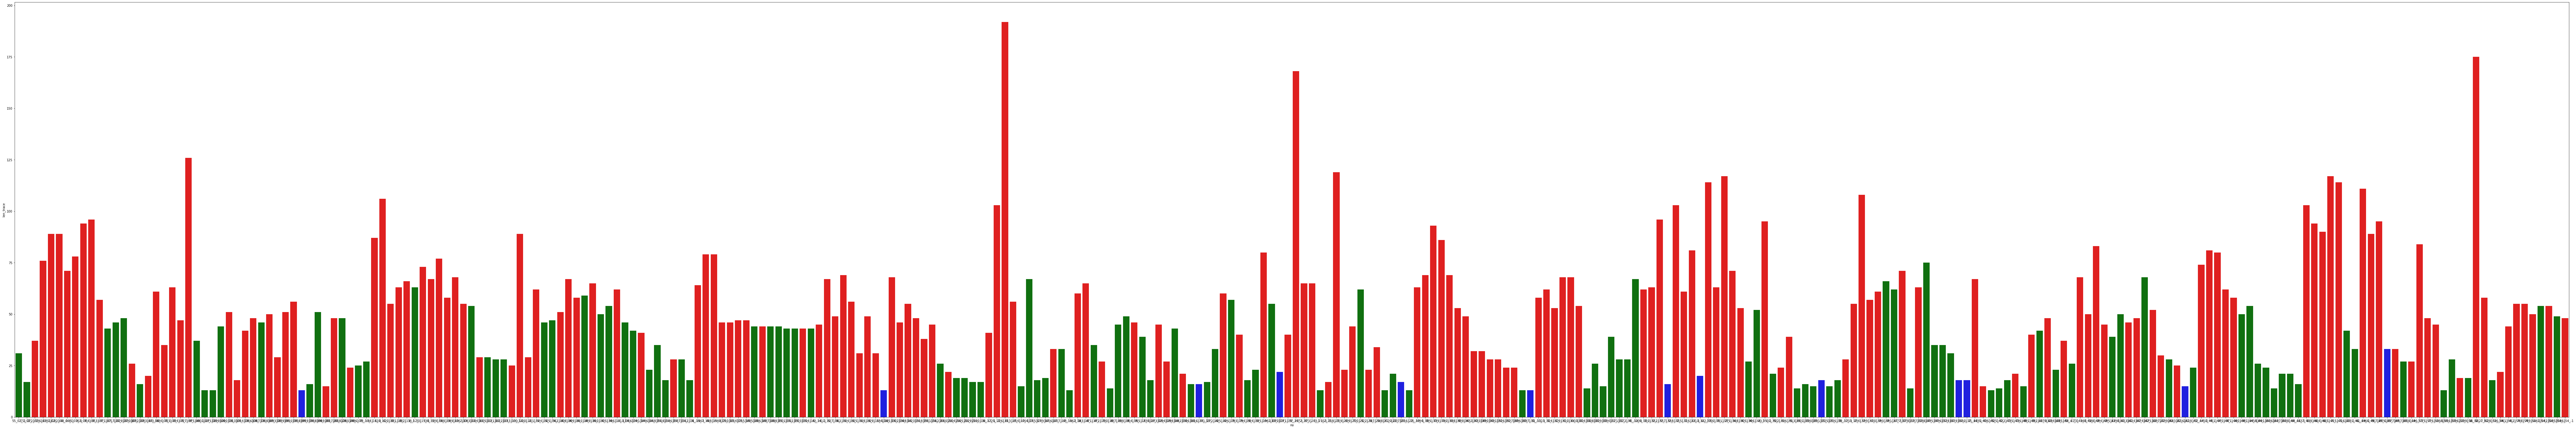

In [144]:
plt_hist(plt_data)

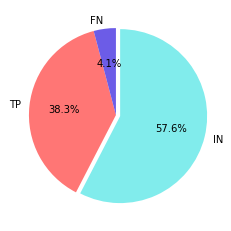

In [145]:
plt_pie(plt_data)

(11244, 17)
4443 1261 4361 1179 316 565
303 386 542 195


len -> fp_tn: 363, fp_ls: 386, tn_ls: 542
len -> tp_fn: 182, tp_ls: 303, fn_ls: 195


/tmp/ipykernel_65666/2002729615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_tp['kind'] = 'TP'
/tmp/ipykernel_65666/2002729615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_indf_fn['kind'] = 'FN'
/tmp/ipykernel_65666/2002729615.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
for i in [val_indf_tp, val_indf_in, val_indf_fn]:
    print(i.shape)

(121, 3)
(182, 3)
(13, 3)


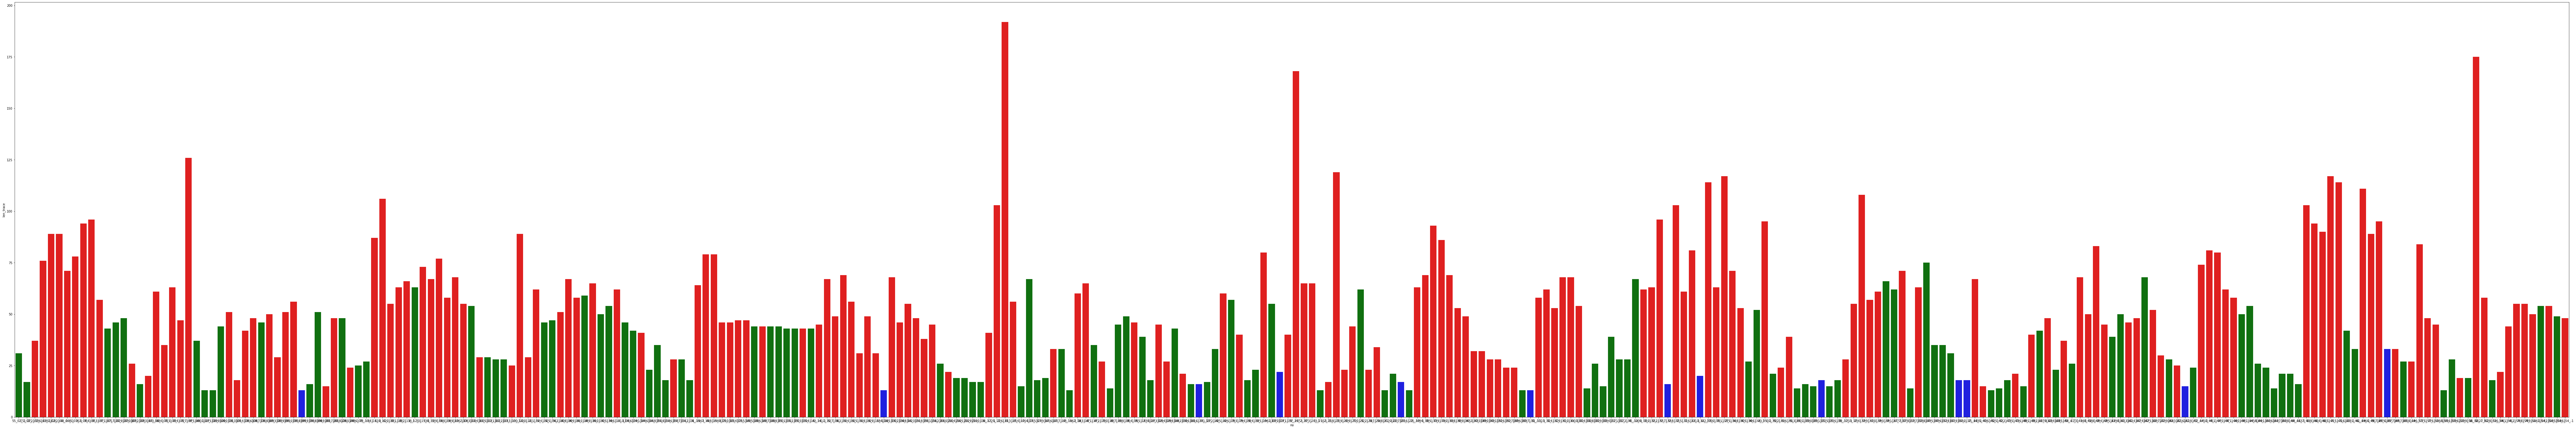

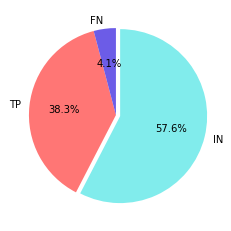

In [ ]:
freq

IN    182
TP    121
FN     13
Name: kind, dtype: int64